# Fit CO2 concentration in atmosphere versus time

We first grab the CO2 data (I put them on the repo to avoid problems with the NOAA server...) and plot them, and try to fit them with different functions (polynomial and power law).

Data are at the address ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy
from scipy.optimize import curve_fit 

import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...

# We fix the random seed to always get the same problem
np.random.seed(seed=42)

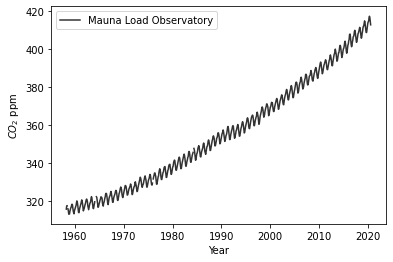

In [3]:
dat = pd.read_table('co2_mm_mlo.txt',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', 'co2_trend', 'days']

# let's plot those data
plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

In [4]:
# let's make sure there is no NAN (missing values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data

A viable forward model for our problem could be :

In [5]:
def forward_model(time, p0, p1, p2, p3, phase, amp):
    seasonal = np.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# Fit it !

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

X, y = dat.loc[:, 'dec_year'].values, dat.loc[:, 'co2_av'].values

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X.reshape(-1,1), y.reshape(-1,1))

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 5.47**2 * RBF(length_scale=87.7) + 0.324**2 * RBF(length_scale=444) * ExpSineSquared(length_scale=2.86, periodicity=1) + 0.388**2 * RationalQuadratic(alpha=0.0386, length_scale=41.1) + 0.0174**2 * RBF(length_scale=1.04) + WhiteKernel(noise_level=0.001)
Log-marginal-likelihood: 1281.799


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


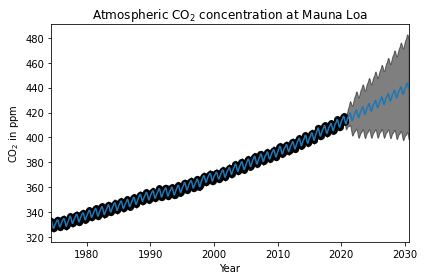

In [25]:
# let's plot those data
plt.scatter(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')
# Illustration
X_ = np.linspace(X.min(), X.max() + 10, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

plt.plot(X_, y_pred)
plt.fill_between(X_.ravel(), y_pred.ravel() - y_std.ravel(), y_pred.ravel() + y_std.ravel(),
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()